In [1]:
from __future__ import print_function
%matplotlib inline

from sklearn import cluster
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import cv2
import numpy as np
import math

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

# SIFT image features extraction and comparison for set of images 

In [2]:
img_832_29856 = cv2.imread('/home/raj/github/glioma_histo_img_classifier_lob/images/TCGA-02-0001-01Z-00-DX2_20x_832_29856_256x256.png')
img_4768_25216 = cv2.imread('/home/raj/github/glioma_histo_img_classifier_lob/images/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
img_15424_10336 = cv2.imread('/home/raj/github/glioma_histo_img_classifier_lob/images/TCGA-02-0001-01Z-00-DX2_20x_15424_10336_256x256.png')

def show_rgb_img(img):
    """Convenience function to display a typical color image"""
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

In [3]:
def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

img_832_29856_gray = to_gray(img_832_29856)
img_4768_25216_gray = to_gray(img_4768_25216)
img_15424_10336_gray = to_gray(img_15424_10336)

#plt.imshow(img_832_29856_gray, cmap='gray');

Here are what our SIFT features look like for the image:


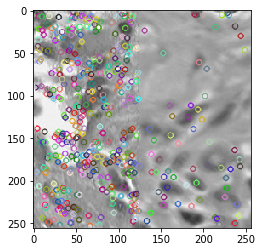

In [21]:
def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

# generate SIFT keypoints and descriptors
img_832_29856_kp, img_832_29856_desc = gen_sift_features(img_832_29856_gray)
img_4768_25216_kp, img_4768_25216_desc = gen_sift_features(img_4768_25216_gray)

print ("Here are what our SIFT features look like for the image:")
show_sift_features(img_832_29856_gray, img_832_29856, img_832_29856_kp);

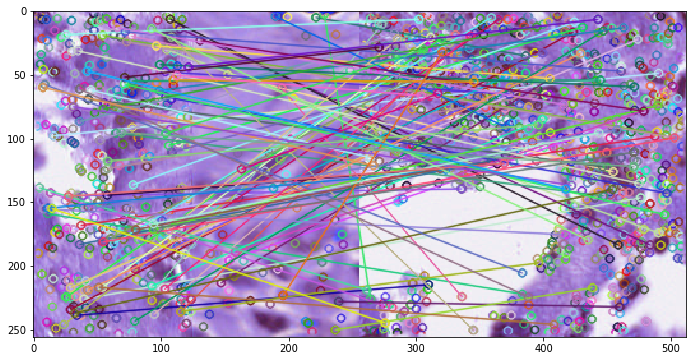

In [5]:
# create a BFMatcher object which will match up the SIFT features for two images
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(img_832_29856_desc, img_4768_25216_desc)

# Sort the matches in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# draw the top N matches
N_MATCHES = 100

match_img = cv2.drawMatches(
    img_832_29856, img_832_29856_kp,
    img_4768_25216, img_4768_25216_kp,
    matches[:N_MATCHES], img_4768_25216.copy(), flags=0)

plt.figure(figsize=(12,6))
plt.imshow(match_img);

In [38]:
# Extracted keypoints from the images
def explain_keypoint(kp):
    print ("Angle:", kp.angle)
    print ("class_id:", kp.class_id)
    print ("octave(image scale where feature is strongest):", kp.octave)
    print ("pt (x,y):", kp.pt)
    print ('response:', kp.response)
    print ("size:", kp.size)

In [35]:
len(img_4768_25216_kp)

960

In [39]:
explain_keypoint(img_4768_25216_kp[0])

Angle: 222.45664978
class_id: -1
octave(image scale where feature is strongest): 5767679
pt (x,y): (2.536571979522705, 253.0909881591797)
response: 0.0286898352206
size: 1.94529950619


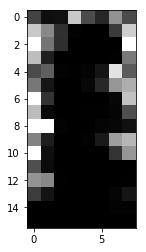

In [7]:
# visualized another way:
plt.imshow(img_832_29856_desc[0].reshape(16,8), interpolation='none');

### SIFT feature extractions for set of images

In [8]:
# defining feature extractor that we want to use
extractor = cv2.xfeatures2d.SIFT_create()

def features(image, extractor):
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return keypoints, descriptors

In [9]:
image_path = "/home/raj/github/glioma_histo_img_classifier_lob/images/*.*"

import glob
descriptor_list = []
filenames = glob.glob(image_path)
images = [cv2.imread(image) for image in filenames] 
extractor = cv2.xfeatures2d.SIFT_create()

for image in images: 
    image = to_gray(image)
    keypoint, descriptor = features(image, extractor)
    if (descriptor is not None):
        descriptor_list.append(descriptor)        

In [10]:
def build_histogram(descriptor_list, cluster_alg):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result =  cluster_alg.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram

In [11]:
# k-means clustering extracted SIFT features to match the nearest centroid
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 489)
kmeans.fit(descriptor)

filenames = glob.glob(image_path)
images = [cv2.imread(image) for image in filenames] 

preprocessed_image = []
for image in images:
      image = to_gray(image)
      keypoint, descriptor = features(image, extractor)
      if (descriptor is not None):
          histogram = build_histogram(descriptor, kmeans)
          preprocessed_image.append(histogram)

In [12]:
image1= "/media/raj/Raj1_5/10ktiles_glioma/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_10816_1984_256x256.png"

In [13]:
# To find the image's nearest neighbour from the extracted SIFT descriptors, BoVW
from sklearn.neighbors import NearestNeighbors

image1 = cv2.imread("/media/raj/Raj1_5/10ktiles_glioma/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_10816_1984_256x256.png")
image = to_gray(image1)
keypoint, descriptor = features(image1, extractor)
histogram = build_histogram(descriptor, kmeans)
neighbor = NearestNeighbors(n_neighbors = 3)
neighbor.fit(preprocessed_image)
dist, result = neighbor.kneighbors([histogram])